# Data Loading Helper Classes and Types

> This notebook contains helper classes and types for loading data from media datasets.

In [2]:
#| default_exp utils.data_loading

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

In [4]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [5]:
#| export
from __future__ import annotations

import xarray as xr
import pandas as pd
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import jax
import jax.numpy as jnp
from jax import random as rnd
#import haruspex.utils.xarray_jax as xj
from typing import (
    Dict, Union, Literal, 
    Optional, Set, Tuple, 
    List, Callable, Generator)
import warnings
import os
import json
from pathlib import Path


In [6]:
#| hide
npy.set_platform("cpu")
npy.set_host_device_count(4)

In [7]:
#| hide
warnings.filterwarnings("ignore")

In [8]:
#| export
def key_gen(
  seed: int # seed for the random number generator
  ) -> Generator:
    key = rnd.PRNGKey(seed)
    while True:
      key, subkey = rnd.split(key, 2)
      yield subkey

In [9]:
keys = key_gen(0)
next(keys)

Array([2718843009, 1272950319], dtype=uint32)

In [10]:
#| echo: false
mff = pd.read_csv(
  '../data/fake_mff.csv'
)
mff["Period"] = pd.to_datetime(mff["Period"])
mff.head()

,Period,Geography,Product,Campaign,Outlet,Creative,VariableName,VariableValue
0,2020-01-06,NY,X,A,YouTube,15,OLV Impressions,1593.181916
1,2020-01-06,NY,X,A,YouTube,30,OLV Impressions,2197.973430
2,2020-01-06,NY,X,A,Prime,15,OLV Impressions,3580.033462
3,2020-01-06,NY,X,A,Prime,30,OLV Impressions,2968.180363
4,2020-01-06,NY,X,B,YouTube,15,OLV Impressions,0.000000


In [11]:
#| export
def build_datatree(
  mff: pd.DataFrame, # Dataframe in long format
  var_groups: Dict[str, List[str]], # Dictionary of variable groups
  group_common_coords: Dict[str, Union[Dict[str, List], List]], # Dictionary of common coords for each group or list of common dimensions
  ) -> xr.DataTree: # Returns a DataTree object
  "DataTree object"
  
  data_tree_dict = {}
  
  if isinstance(list(group_common_coords.values())[0], list):
      group_common_coords = {".": group_common_coords}
    
  data_tree_dict["."] = xr.Dataset(coords=group_common_coords['.'])
  for var_group in var_groups:
    if var_group=='.': continue
    data_tree_dict[f'/{var_group}'] = xr.Dataset(coords=group_common_coords.get(var_group, {}))
    for var in var_groups[var_group]:
      data = mff.query("VariableName == @var").set_index(
          ["Period", "Geography", "Product", "Campaign", "Outlet", "Creative"]
        )[['VariableValue']]
      data_tree_dict[f'/{var_group}/{var}'] = xr.Dataset.from_dataframe(
        data
      )
  
  return xr.DataTree.from_dict(data_tree_dict)

In [12]:
var_names = np.unique(mff["VariableName"])
media_var_names = [var_name for var_name in var_names if "Impressions" in var_name]
target_var_name = "Sales"
holiday_var_names = [var_name.replace("Holiday_", "") for var_name in var_names if "Holiday" in var_name]
exog_var_names = [var_name for var_name in var_names if (
  (var_name not in media_var_names) and 
  (var_name != target_var_name) and 
  (var_name.replace("Holiday_", "") not in holiday_var_names))]
mff_clean = mff.copy()
mff_clean["VariableName"] = mff_clean["VariableName"].str.replace("Holiday_", "", regex=False)

In [13]:
jax.numpy.asarray(mff_clean.query("VariableName in @holiday_var_names").set_index(["Period","Product", "Geography"])['VariableValue'])

Array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [14]:
data_tree = build_datatree(
  mff_clean,
  var_groups={
    "exog": exog_var_names, 
    "exog/media": media_var_names, 
    "exog/holiday": holiday_var_names, 
    "target": [target_var_name]
    },
  group_common_coords={
    ".": {
      "Period": mff['Period'].sort_values().unique(),
      "Geography": mff["Geography"].sort_values().unique(),
      "Product": mff["Product"].sort_values().unique()
    },
    "exog/media": {
      "Period": mff['Period'].sort_values().unique(),
      "Geography":mff["Geography"].sort_values().unique(),
      "Product": mff["Product"].sort_values().unique(),
      "Campaign": (
        mff
          .query("VariableName in @media_var_names")["Campaign"]
          .sort_values()
          .unique()
        ),
    },
  }
)

In [15]:
data_tree['exog']

<xarray.DataTree 'exog'>
Group: /exog
│   Dimensions:    (Period: 208, Geography: 4, Product: 2)
│   Inherited coordinates:
│     * Period     (Period) datetime64[ns] 2kB 2020-01-06 2020-01-13 ... 2023-12-25
│     * Geography  (Geography) object 32B 'CA' 'ME' 'NY' 'TX'
│     * Product    (Product) object 16B 'X' 'Y'
├── Group: /exog/Price
│       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 1,
│                           Outlet: 1, Creative: 1)
│       Coordinates:
│         * Campaign       (Campaign) object 8B 'Total'
│         * Outlet         (Outlet) object 8B 'Total'
│         * Creative       (Creative) object 8B 'Total'
│       Data variables:
│           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 13kB ...
├── Group: /exog/Unit Sales
│       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 1,
│                           Outlet: 1, Creative: 1)
│       Coordinates:
│         * Campaign       (Campaign) object 8B 'Total'
│         * Outlet         (Outlet) object 8B 'Total'
│         * Creative       (Creative) object 8B 'Total'
│       Data variables:
│           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 13kB ...
├── Group: /exog/media
│   │   Dimensions:    (Campaign: 3)
│   │   Coordinates:
│   │     * Campaign   (Campaign) object 24B 'A' 'B' 'C'
│   ├── Group: /exog/media/Audio Impressions
│   │       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 3,
│   │                           Outlet: 2, Creative: 2)
│   │       Coordinates:
│   │         * Outlet         (Outlet) object 16B 'Pandora' 'Spotify'
│   │         * Creative       (Creative) object 16B 'Podcast' 'Streamming'
│   │       Data variables:
│   │           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 160kB ...
│   ├── Group: /exog/media/Display Impressions
│   │       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 3,
│   │                           Outlet: 2, Creative: 3)
│   │       Coordinates:
│   │         * Outlet         (Outlet) object 16B 'DVM' 'Yahoo'
│   │         * Creative       (Creative) object 24B 'Desktop-Large' ... 'Mobile'
│   │       Data variables:
│   │           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 240kB ...
│   ├── Group: /exog/media/OLV Impressions
│   │       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 3,
│   │                           Outlet: 2, Creative: 2)
│   │       Coordinates:
│   │         * Outlet         (Outlet) object 16B 'Prime' 'YouTube'
│   │         * Creative       (Creative) object 16B '15' '30'
│   │       Data variables:
│   │           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 160kB ...
│   └── Group: /exog/media/Social Impressions
│           Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 3,
│                               Outlet: 3, Creative: 2)
│           Coordinates:
│             * Outlet         (Outlet) object 24B 'Facebook' 'Instagram' 'Snapchat'
│             * Creative       (Creative) object 16B 'Image' 'Video'
│           Data variables:
│               VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 240kB ...
└── Group: /exog/holiday
    ├── Group: /exog/holiday/Birthday of Martin Luther King, Jr.
    │       Dimensions:        (Period: 208, Geography: 4, Product: 2, Campaign: 1,
    │                           Outlet: 1, Creative: 1)
    │       Coordinates:
    │         * Campaign       (Campaign) object 8B 'Total'
    │         * Outlet         (Outlet) object 8B 'Total'
    │         * Creative       (Creative) object 8B 'Total'
    │       Data variables:
    │           VariableValue  (Period, Geography, Product, Campaign, Outlet, Creative) float64 13kB ...
    ├── Group: /exog/holiday/Christmas Day
    │       Dimensions:        (Period:

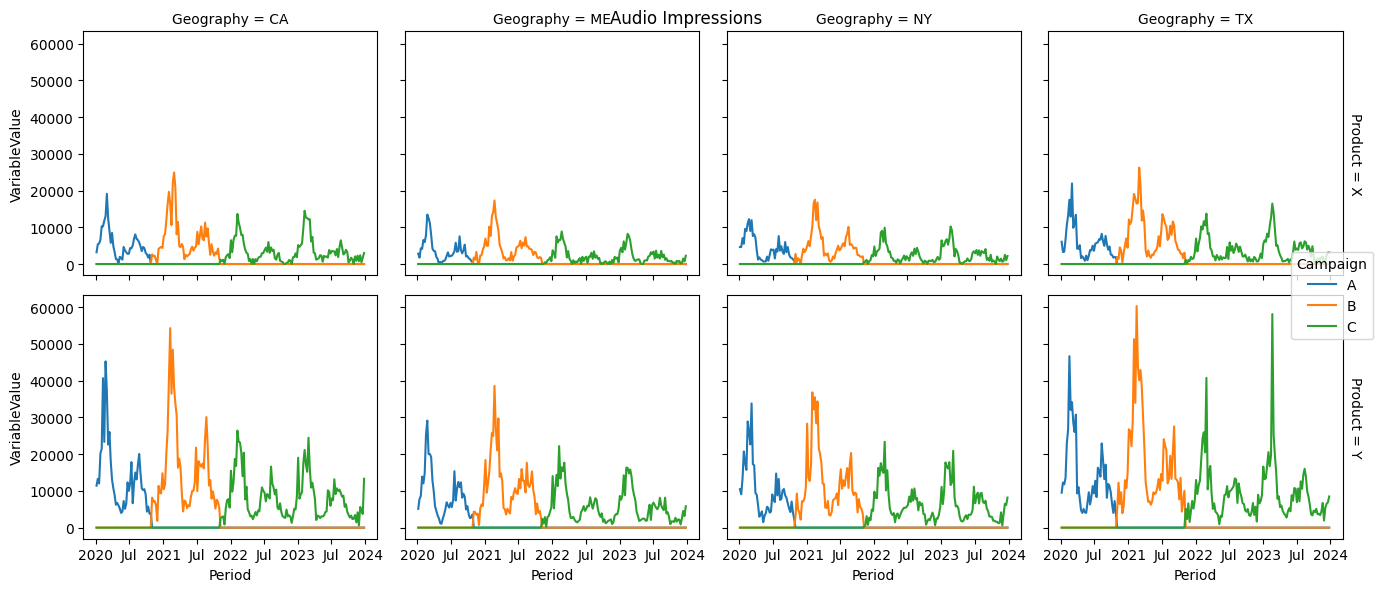

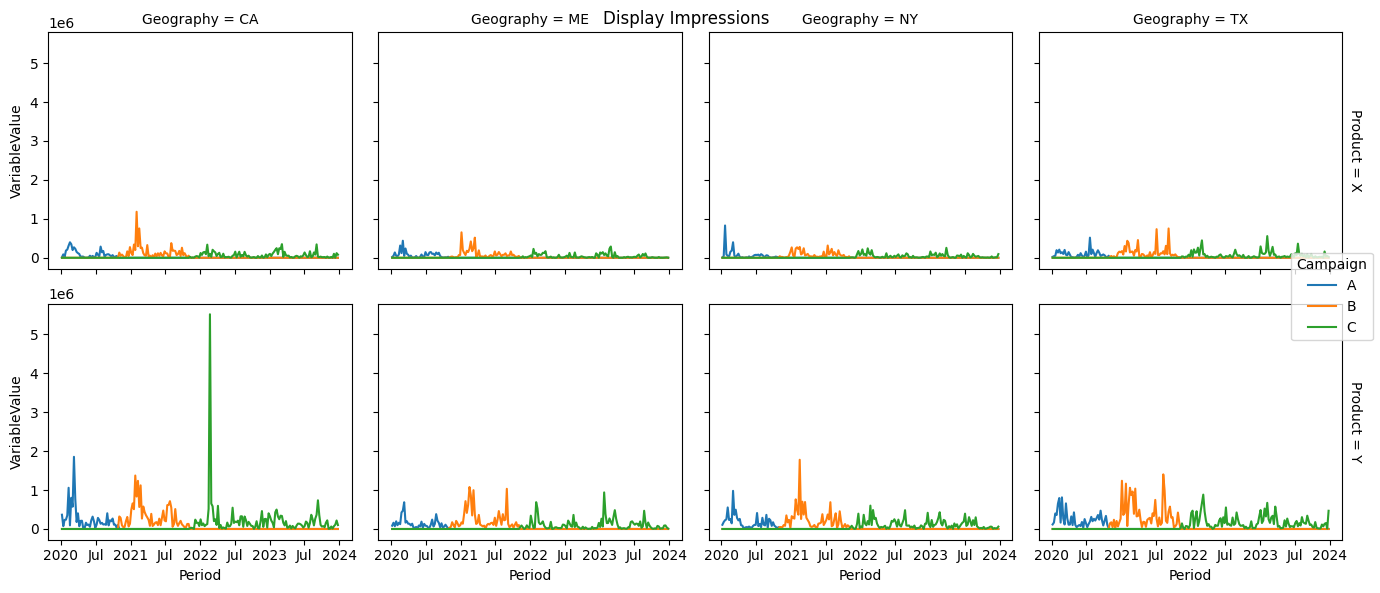

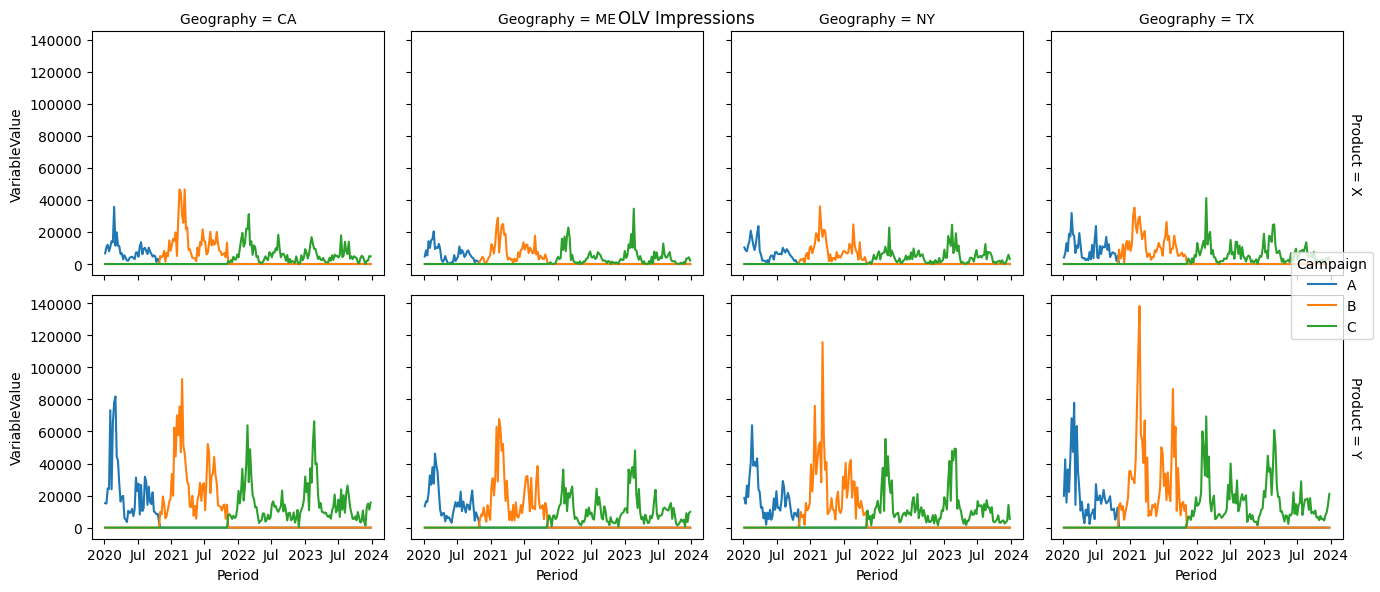

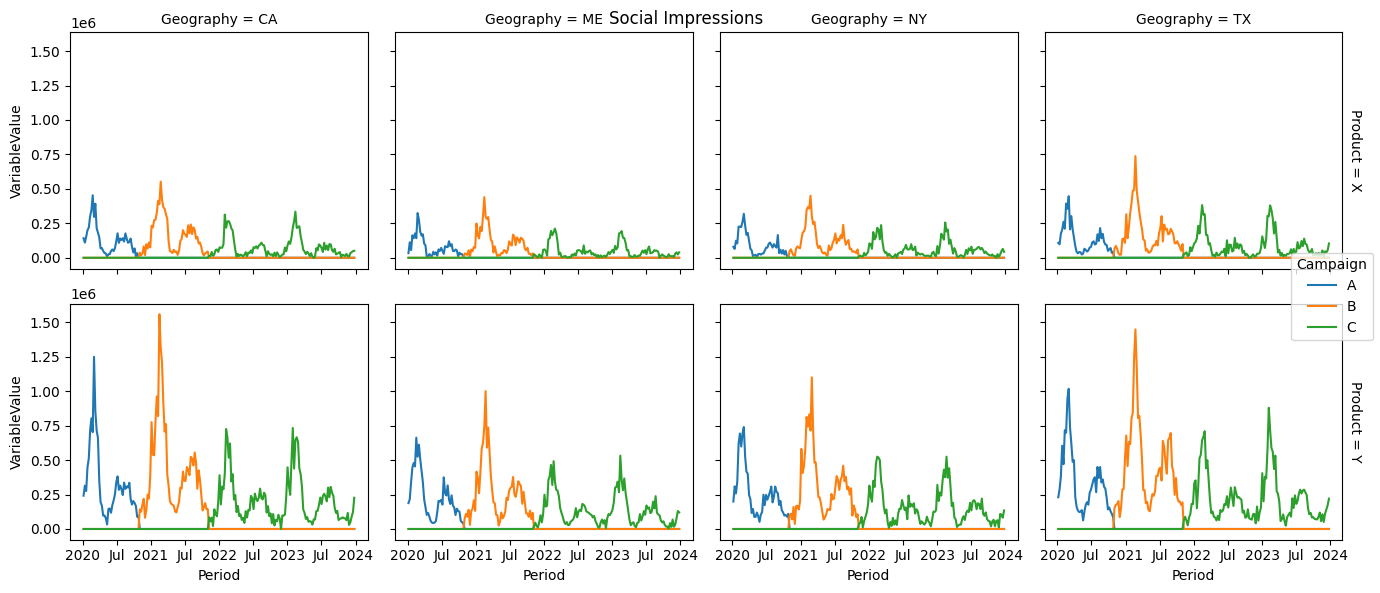

In [16]:
for group in data_tree['exog']['media']:
  
  (
    data_tree['exog']['media'][group]
      .VariableValue
      .sum(dim=["Creative", "Outlet"])
      .plot(x="Period", hue="Campaign", col="Geography", row="Product"))
  
  plt.tight_layout()
  plt.suptitle(group);

In [17]:
#| hide
X=rnd.normal(next(keys), (156,2)) 
betas = rnd.normal(next(keys), (2,))
y = X @ betas + 0.1*rnd.normal(next(keys), (156,))

dataset = xr.Dataset(
  {
    "X": (("sample", "feature"), X), 
    "y": ("sample", y)
  },
  coords = {
    "sample": np.arange(156),
    "feature": np.arange(2)
  }
)

In [18]:
list(data_tree['target'].dims)

['Period', 'Geography', 'Product']

In [27]:
#| export
def hierarchical_model(
  data_tree: xr.DataTree, # DataTree object
  has_intercept: bool = True, # Whether to include an intercept
  ):
  "Hierarchical model"
  y = data_tree['target'][list(data_tree['target'])[0]].VariableValue
  y_mean = y.mean(...)
  y_std = y.std(...)
  y = ((y-y_mean)/y_std).values
  X = data_tree['exog']
  target_dims = list(data_tree['target'].dims)
  
  mu = 0
  if has_intercept:
    mu = mu + npy.sample("intercept", dist.Normal(0, 1))

  
  for node in X.leaves:
    node_dims = list(node.dims)
    
    if node_dims != target_dims:
      node_values = node.VariableValue.groupby(target_dims).sum(...)
      node_mean = node_values.mean(...)
      node_std = node_values.std(...)
      node_values = (node_values - node_mean) / node_std
      node_values = node_values.values
    else:
      node_values = node
      node_mean = node_values.mean(...)
      node_std = node_values.std(...)
      node_values = (node_values - node_mean) / node_std
      node_values = node_values.values
    coeff = npy.sample("coeff_{}_std".format(node.name), dist.Normal(0, 1))
    mu = mu + coeff * node_values
    npy.deterministic("coeff_{}".format(node.name), coeff*y_std.values/node_std.values)
  sigma = npy.sample("sigma", dist.HalfCauchy(1))
  return npy.sample("y", dist.Normal(mu, sigma), obs=y)
    
    


In [28]:
predictive_hierarchical_modl = Predictive(hierarchical_model, num_samples=1000)(next(keys), data_tree)


In [29]:
#| export
def ols_model(
    x: xr.DataArray, # DataArray of exogenous variables
    y: xr.DataArray, # DataArray of endogenous variable
    has_intercept: bool=True # whether to include an intercept in the model
    ) -> None:
    
    n, k = x.shape
    beta = npy.sample('beta', npy.distributions.Normal(np.zeros(k), 1))
    #betas = xr.DataArray(beta, coords={'feature': np.arange(2)}, dims=['feature'])
    sigma = npy.sample('sigma', npy.distributions.Exponential(1))
   
    mean = jnp.dot(x.values, beta)
    if has_intercept:
        mean += npy.sample('intercept', npy.distributions.Normal(0, 1))
    npy.sample('y', npy.distributions.Normal(mean, sigma), obs=y.values if y is not None else None)

In [ ]:
mcmc_key = rnd.PRNGKey(1234)
kernel = npy.infer.NUTS(hierarchical_model)
mcmc = npy.infer.MCMC(kernel, num_warmup=250, num_samples=750, num_chains=4)
mcmc.run(mcmc_key, data_tree, has_intercept=True)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
#| hide
import arviz as az

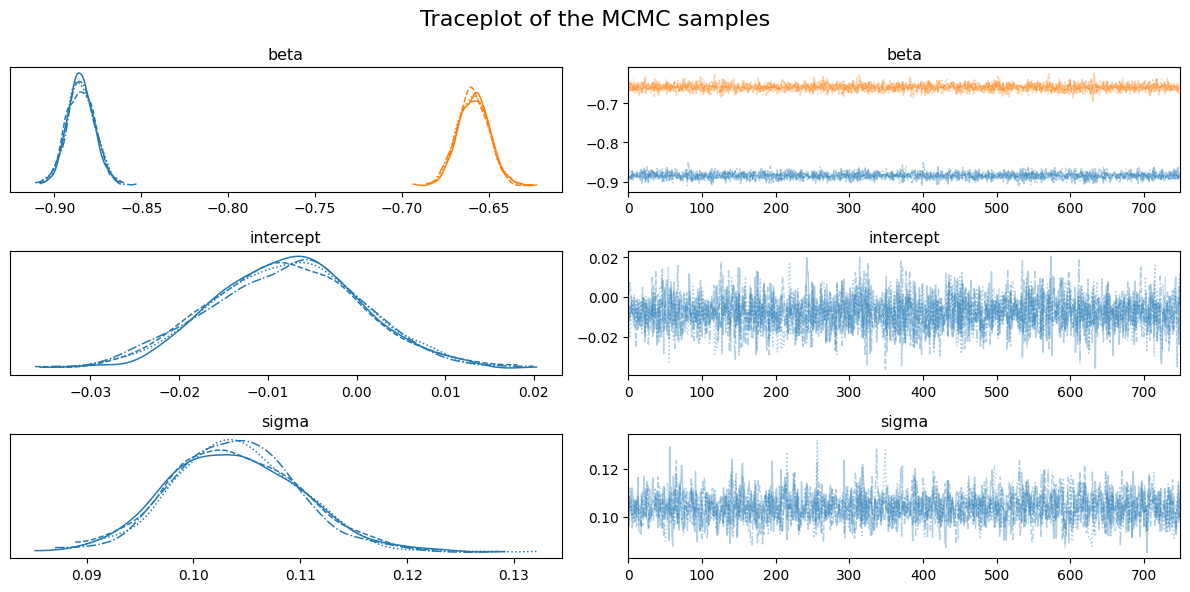

In [42]:
#| echo: false
az.plot_trace(mcmc, backend_kwargs={"layout": "tight"}, compact=True);
plt.suptitle("Traceplot of the MCMC samples", fontsize=16);

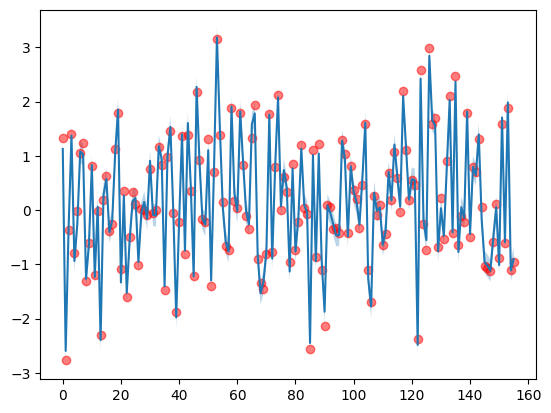

In [ ]:
#| echo: false
predictive_model = Predictive(ols_model, mcmc.get_samples())
predictions = predictive_model(next(keys), dataset["X"], None, has_intercept=True)
plt.plot(predictions["y"].mean(axis=0))
plt.fill_between(np.arange(156), *np.percentile(predictions["y"], [2.5, 97.5], axis=0), alpha=0.3)
plt.scatter(dataset["sample"], dataset["y"], color="red", alpha=0.5)

In [ ]:
#| export
class DataLoader:
    """Load data from a file or a directory of files, while keeping track of the metadata."""
    def __init__(
        self, 
        path: Union[str, Path], # path to the file or directory
        metadata_file_name: Optional[str] = None, # name of the metadata file
        custom_data_loader: Optional[Union[Callable, str]] = None # custom data loader function or name of module with custom data loader
        ) -> DataLoader:
        self.path = Path(path)
        self.metadata_file_name = metadata_file_name
        self.custom_data_loader = custom_data_loader
        self.data = self._load_data()
        
    def _load_data(self) -> Union[xr.Dataset, Dict[str, xr.Dataset]]:
        if self.path.is_file():
            return self._load_single_file(self.path)
        elif self.path.is_dir():
            return self._load_directory(self.path)
        else:
            raise FileNotFoundError(f"File or directory not found at {self.path}")
        

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()